In [1]:
import pandas as pd
import geopandas as gpd

from shared_utils import rt_utils, catalog_utils, rt_dates, webmap_utils, gtfs_utils_v2

from calitp_data_analysis import get_fs, geography_utils
from segment_speed_utils import helpers, time_series_utils, gtfs_schedule_wrangling, corridor_analysis
from segment_speed_utils.project_vars import SCHED_GCS, SEGMENT_GCS, GTFS_DATA_DICT, COMPILED_CACHED_VIEWS, PROJECT_CRS
import numpy as np
import datetime as dt
from calitp_data_analysis.gcs_geopandas import GCSGeoPandas
gcsgp = GCSGeoPandas()
ADHOC_PATH = "gs://calitp-analytics-data/data-analyses/rt_segment_speeds/adhoc/"

In [2]:
target_mph = 16
target_mps = target_mph / rt_utils.MPH_PER_MPS

In [3]:
SEGMENT_GCS

'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/'

# Lincoln Corridor Speed History

* support D7 Lincoln Bus Lane Feasibility Study by illustrating worsening speeds and bus rider delay over the last few years
* will refactor into a script pending speedmap segments work (goal is to align on those)

## refactor to use corridor analysis tooling

In [4]:
analysis_date = rt_dates.DATES['mar2023']

In [5]:
segment_speeds = corridor_analysis.import_speedmap_segment_speeds(analysis_date)

frequencies = corridor_analysis.get_max_frequencies(segment_speeds)

trip_speeds = corridor_analysis.import_trip_speeds(analysis_date)

2.0 percent of segments have no speed


In [6]:
# corr = pd.read_excel(f'{ADHOC_PATH}corr_hs.xlsx', sheet_name='Corridor Input')
# corr = corr.astype({'start_segment_id': str, 'end_segment_id': str, 'shape_id':str})

In [7]:
# row = corr.loc[21]

In [8]:
# corr_gdf = corridor_analysis.corridor_from_segments(speed_segments_gdf=segment_speeds,
#                                                organization_source_record_id=row.organization_source_record_id,
#                                                shape_id=row.shape_id,
#                                                start_seg_id=row.start_segment_id,
#                                                end_seg_id=row.end_segment_id)

In [9]:
# corr_gdf.to_parquet(f'{ADHOC_PATH}lincoln_corridor.parquet', filesystem=fs)

In [10]:
corr_gdf = gcsgp.read_parquet(f'{ADHOC_PATH}lincoln_corridor.parquet')

In [11]:
corridor_trips = corridor_analysis.find_corridor_data(segment_speeds, corr_gdf, trip_speeds,
                                                     custom_relevance_meters=5000
                                                     )

In [12]:
if 'route_short_name' not in corridor_trips.columns:

    trips = helpers.import_scheduled_trips(analysis_date, columns=['gtfs_dataset_key', 'route_id', 'route_short_name'])
    trips = trips.rename(columns={'gtfs_dataset_key':'schedule_gtfs_dataset_key'}).drop_duplicates()
    corridor_trips = corridor_trips.merge(trips, on =['schedule_gtfs_dataset_key', 'route_id'])

In [13]:
corridor_results = corridor_analysis.analyze_corridor_trips(corridor_trips)

0.0 percent of trips with zero seconds
0.6 percent of trips with speeds > 80mph or < 3mph


In [14]:
# corridor_analysis.validate_corridor_routes(corr_gdf, corridor_trips)

In [15]:
corridor_improvements = corridor_analysis.analyze_corridor_improvements(corridor_results, **{'trip_mph_floor': 16, 'trip_percent_speedup': 15})

median: 13.36mph... mph floor mode: 16mph


In [16]:
corridor_improvements

,trip_instance_key,corridor_meters,corridor_seconds,corridor_speed_mps,corridor_speed_mph,route_short_name,route_id,shape_array_key,shape_id,schedule_gtfs_dataset_key,time_of_day,corridor_id,improved_corridor_speed_mph,intervention_assumption,improved_corridor_speed_mps,improved_corridor_seconds
0,012d2b7d1e5d77757ebb2414bbeedfae,7823.383,1389.0,5.632385,12.599646,3,3556,95fcdc2f2f2e180e04129bfd4829a239,26171,dbbe8ee4864a2715a40749605395d584,AM Peak,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1093.806736
1,05336b499070f87c7f6b4c8cf1c9172a,7823.383,1214.0,6.444302,14.415904,3,3556,95fcdc2f2f2e180e04129bfd4829a239,26171,dbbe8ee4864a2715a40749605395d584,Midday,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1093.806736
2,0628c213593d3b31d6ca00d1e4b81062,7823.383,1353.0,5.782249,12.934891,3,3556,95fcdc2f2f2e180e04129bfd4829a239,26171,dbbe8ee4864a2715a40749605395d584,Midday,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1093.806736
3,06ca5ebc8bc10cc28f1ec25b7e8a1d99,7742.892,1188.0,6.517586,14.579840,3,3556,74bce719e55c7a06caccbbd54c797fcf,26172,dbbe8ee4864a2715a40749605395d584,Evening,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1082.553088
4,08c415d5ca6ef9453381b97dcc2c1b58,8692.928,1599.0,5.436478,12.161401,R3,3570,026eed166fdb96c4be63f7693aa794b0,26219,dbbe8ee4864a2715a40749605395d584,AM Peak,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1215.379996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,fd9f001bcb7ab00019f453a72fdf563c,7742.892,1740.0,4.449938,9.954511,3,3556,74bce719e55c7a06caccbbd54c797fcf,26172,dbbe8ee4864a2715a40749605395d584,PM Peak,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1082.553088
151,fdcf0f29931f5d955bbb88c6cc8f5423,7742.892,1141.0,6.786058,15.180411,3,3556,74bce719e55c7a06caccbbd54c797fcf,26172,dbbe8ee4864a2715a40749605395d584,Midday,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1082.553088
152,fe4071eea14b27590e904a88190b328b,7742.892,1341.0,5.773969,12.916368,3,3556,74bce719e55c7a06caccbbd54c797fcf,26172,dbbe8ee4864a2715a40749605395d584,AM Peak,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1082.553088
153,ff0a5068f000cf3c2edffb2f838699a2,7823.383,1399.0,5.592125,12.509584,3,3556,95fcdc2f2f2e180e04129bfd4829a239,26171,dbbe8ee4864a2715a40749605395d584,PM Peak,584447099936112567,16.0,trips achieve 16mph or existing spd if higher,7.152436,1093.806736


In [17]:
summarized = corridor_analysis.summarize_corridor_improvements(corridor_improvements, frequencies, corr_gdf)

In [18]:
summarized = summarized.assign(delay_per_trip = summarized.delay_minutes / summarized.n_trips_daily,
                              analysis_date = analysis_date)

In [19]:
def new_lincoln(analysis_date, corr_gdf = corr_gdf):
    
    try:
        segment_speeds = corridor_analysis.import_speedmap_segment_speeds(analysis_date)
        frequencies = corridor_analysis.get_max_frequencies(segment_speeds)
        trip_speeds = corridor_analysis.import_trip_speeds(analysis_date)
        corridor_trips = corridor_analysis.find_corridor_data(segment_speeds, corr_gdf, trip_speeds,
                                                         custom_relevance_meters=5000
                                                         )
        if 'route_short_name' not in corridor_trips.columns:

            trips = helpers.import_scheduled_trips(analysis_date, columns=['gtfs_dataset_key', 'route_id', 'route_short_name'])
            trips = trips.rename(columns={'gtfs_dataset_key':'schedule_gtfs_dataset_key'}).drop_duplicates()
            corridor_trips = corridor_trips.merge(trips, on =['schedule_gtfs_dataset_key', 'route_id'])

        corridor_results = corridor_analysis.analyze_corridor_trips(corridor_trips)
        corridor_improvements = corridor_analysis.analyze_corridor_improvements(corridor_results, **{'trip_mph_floor': 16, 'trip_percent_speedup': 15})
        summarized = corridor_analysis.summarize_corridor_improvements(corridor_improvements, frequencies, corr_gdf)
        summarized = summarized.assign(delay_per_trip = summarized.delay_minutes / summarized.n_trips_daily,
                                  analysis_date = analysis_date)
        return summarized
    
    except Exception as e:
        print(f'{analysis_date} failed')
        print(e)
        return

In [20]:
all_summaries = []

In [21]:
for key in rt_dates.DATES.keys():
    date = rt_dates.DATES[key]
    print(date)
    all_summaries += [new_lincoln(date)]

2023-03-15
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
0.6 percent of trips with speeds > 80mph or < 3mph
median: 13.36mph... mph floor mode: 16mph
2023-04-10
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
1.3 percent of trips with speeds > 80mph or < 3mph
median: 13.34mph... mph floor mode: 16mph
2023-04-11
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
1.4 percent of trips with speeds > 80mph or < 3mph
median: 13.0mph... mph floor mode: 16mph
2023-04-12
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
0.0 percent of trips with speeds > 80mph or < 3mph
median: 12.71mph... mph floor mode: 16mph
2023-04-13
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
0.0 percent of trips with speeds > 80mph or < 3mph
median: 13.47mph... mph floor mode: 16mph
2023-04-14
2.0 percent of segments have no speed
0.0 percent of trips with zero seconds
0.0 perc

In [22]:
all_df = pd.concat(all_summaries)

<Axes: >

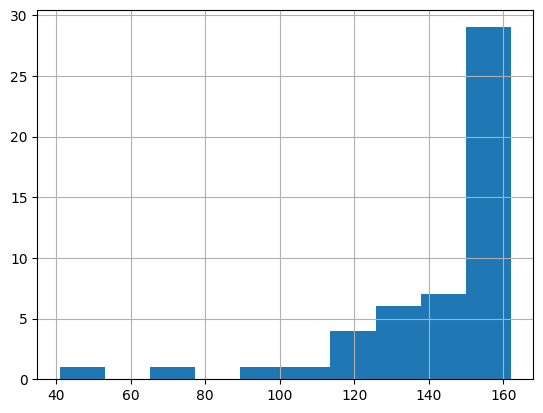

In [23]:
all_df.n_trips_daily.hist()

In [24]:
all_df = all_df.query('n_trips_daily > 140')

In [25]:
import altair as alt

In [26]:
all_df.analysis_date = all_df.analysis_date.apply(lambda x: pd.Timestamp(x))

In [27]:
chart = alt.Chart(all_df).mark_point().encode(
    x=alt.X('analysis_date:T', axis = alt.Axis(title = 'Date', format = ("%b %Y"))),
    y=alt.Y('delay_per_trip', title='Delay Per Trip (minutes)')
).properties(width=600, height=400)

chart + chart.transform_regression('analysis_date', 'delay_per_trip').mark_line()

alt.LayerChart(...)

In [28]:
# all_df.to_csv('lincoln_June_2025.csv')